## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments, predicting a binary mutated/not mutated label for each gene (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dir, 'mutation_imputed_n10_i5', 'gene').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')
print(results_df.shape)
results_df.head()

(9468, 9)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.50000,0.083933,MAP3K1,expression,shuffled,42,train,0,gene
1,0.50000,0.052632,MAP3K1,expression,shuffled,42,test,0,gene
2,0.51586,0.091304,MAP3K1,expression,shuffled,42,cv,0,gene
3,0.98407,0.843520,MAP3K1,expression,shuffled,42,train,1,gene
4,0.49369,0.074970,MAP3K1,expression,shuffled,42,test,1,gene


In [4]:
expression_df = (
    results_df[results_df.training_data == 'expression']
        .drop(columns=['training_data'])
)
expression_results_df = au.compare_results(expression_df,
                                           identifier='identifier',
                                           metric='aupr',
                                           correction=True,
                                           correction_method='fdr_bh',
                                           correction_alpha=SIG_ALPHA,
                                           verbose=True)
expression_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
expression_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for PTPN11, skipping


,gene,delta_mean,p_value,corr_pval,reject_null
93,TP53,0.406834,1.707727e-18,1.603324e-16,True
25,CTNNB1,0.593111,3.305822e-18,1.603324e-16,True
15,BRAF,0.618616,6.970392e-18,2.253760e-16,True
30,ERBB2,0.577404,4.447770e-17,1.078584e-15,True
5,ARID1A,0.417334,4.015667e-16,7.790394e-15,True
54,KRAS,0.471016,1.551589e-15,2.508402e-14,True
72,PIK3CA,0.340315,4.473142e-15,6.198497e-14,True
22,CIC,0.545687,7.647812e-15,9.272972e-14,True
3,APC,0.570727,9.955581e-15,1.072990e-13,True
10,ATRX,0.456428,1.675192e-14,1.624936e-13,True


In [5]:
methylation_df = (
    results_df[results_df.training_data == 'methylation']
        .drop(columns=['training_data'])
)
methylation_results_df = au.compare_results(methylation_df,
                                            identifier='identifier',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
methylation_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
methylation_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for HIST1H3B, skipping
shapes unequal for MSH2, skipping
shapes unequal for MSH6, skipping
shapes unequal for PTPN11, skipping


,gene,delta_mean,p_value,corr_pval,reject_null
3,APC,0.539381,3.684203e-18,3.536835e-16,True
92,TP53,0.278909,4.008868e-16,1.924256e-14,True
22,CIC,0.437267,1.547273e-15,4.951273e-14,True
15,BRAF,0.498239,4.038294e-15,9.691907e-14,True
46,IDH1,0.435595,4.009300e-14,7.697856e-13,True
67,NRAS,0.296475,4.638053e-12,7.420885e-11,True
28,EGFR,0.267096,1.047483e-11,1.436548e-10,True
76,PTEN,0.354826,2.237498e-11,2.684998e-10,True
54,KRAS,0.241546,5.381405e-11,5.740165e-10,True
10,ATRX,0.356543,7.277408e-11,6.365045e-10,True


5

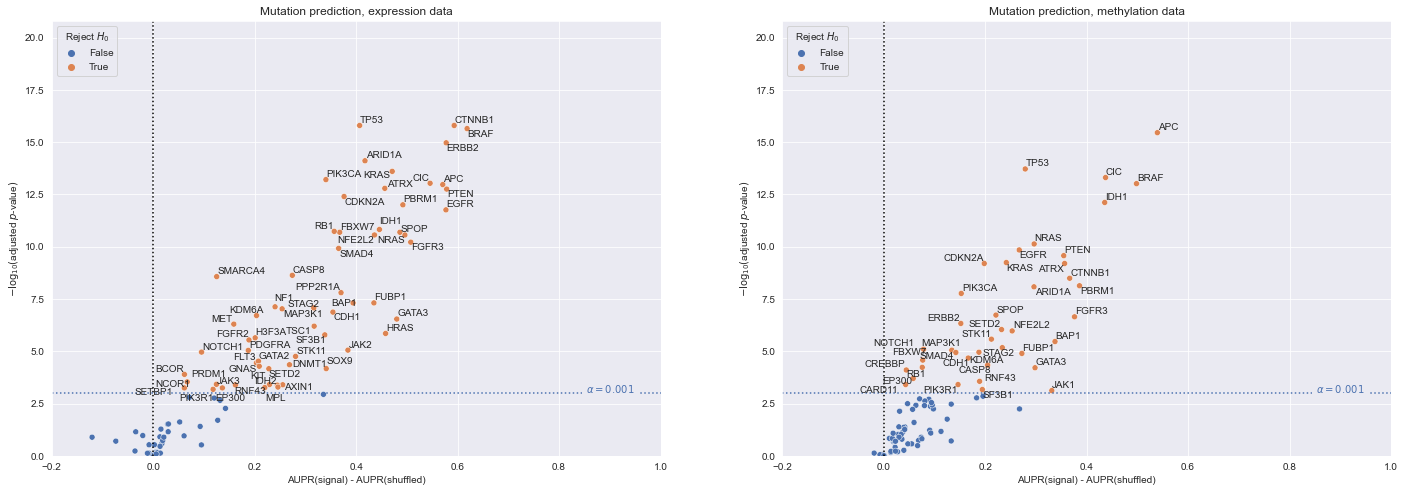

In [6]:
expression_results_df['nlog10_p'] = -np.log10(expression_results_df.corr_pval)
methylation_results_df['nlog10_p'] = -np.log10(methylation_results_df.corr_pval)

sns.set({'figure.figsize': (24, 8)})
fig, axarr = plt.subplots(1, 2)

# plot mutation prediction from expression, in a volcano-like plot
sns.scatterplot(data=expression_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[0])
# add vertical line at 0
axarr[0].axvline(x=0, linestyle=':', color='black')
# add horizontal line at statistical significance threshold
l = axarr[0].axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
# label horizontal line with significance threshold
# (matplotlib makes this fairly difficult, sadly)
axarr[0].text(0.9, -np.log10(SIG_ALPHA)+0.2,
              r'$\alpha = {}$'.format(SIG_ALPHA),
              va='center', ha='center', color=l.get_color(),
              backgroundcolor=axarr[0].get_facecolor())
axarr[0].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[0].set_xlim((-0.2, 1.0))
y_max = max(expression_results_df.nlog10_p.max(), methylation_results_df.nlog10_p.max())
axarr[0].set_ylim((0, y_max+5))
axarr[0].legend(title=r'Reject $H_0$', loc='upper left')
axarr[0].set_title(r'Mutation prediction, expression data')

# plot mutation prediction from methylation, same as above
sns.scatterplot(data=methylation_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[1])
axarr[1].axvline(x=0, linestyle=':', color='black')
l = axarr[1].axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
axarr[1].text(0.9, -np.log10(SIG_ALPHA)+0.2,
              r'$\alpha = {}$'.format(SIG_ALPHA),
              va='center', ha='center', color=l.get_color(),
              backgroundcolor=axarr[0].get_facecolor())
axarr[1].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[1].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[1].set_xlim((-0.2, 1.0))
axarr[1].set_ylim((0, y_max+5))
axarr[1].legend(title=r'Reject $H_0$', loc='upper left')
axarr[1].set_title(r'Mutation prediction, methylation data')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# label genes and adjust text to not overlap
# automatic alignment isn't perfect, can align by hand in inkscape if necessary
text_labels_expression = label_points(expression_results_df['delta_mean'],
                                      expression_results_df['nlog10_p'],
                                      expression_results_df.gene,
                                      expression_results_df.reject_null,
                                      axarr[0])
adjust_text(text_labels_expression,
            ax=axarr[0], 
            expand_text=(1., 1.),
            lim=5)

text_labels_methylation = label_points(methylation_results_df['delta_mean'],
                                       methylation_results_df['nlog10_p'],
                                       methylation_results_df.gene,
                                       methylation_results_df.reject_null,
                                       axarr[1])
adjust_text(text_labels_methylation,
            ax=axarr[1],
            expand_text=(1., 1.),
            lim=5)

In [7]:
compare_results_df = au.compare_results(methylation_df,
                                        pancancer_df=expression_df,
                                        identifier='identifier',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=SIG_ALPHA,
                                        verbose=True)
compare_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
compare_results_df.head()

,gene,delta_mean,p_value,corr_pval,reject_null
0,CTNNB1,0.227291,3.089272e-07,0.000003,True
1,ARID1B,-0.018112,1.372172e-01,0.216327,False
2,TSC1,0.226654,6.825818e-05,0.000332,True
3,CIC,0.111714,2.113956e-05,0.000120,True
4,SPOP,0.270801,2.067940e-07,0.000002,True


5

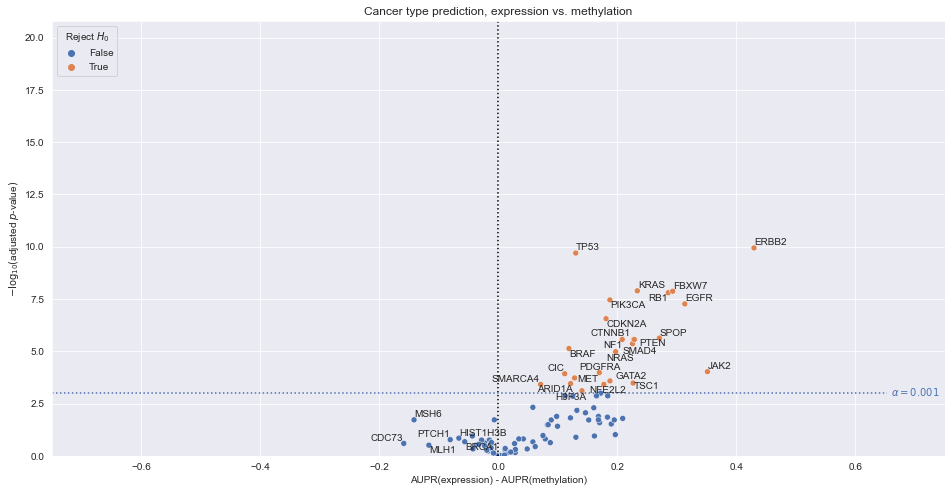

In [8]:
compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)

sns.set({'figure.figsize': (16, 8)})
sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.axvline(x=0, linestyle=':', color='black')
l = plt.axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
plt.text(0.7, -np.log10(SIG_ALPHA)+0.05,
         r'$\alpha = {}$'.format(SIG_ALPHA),
         va='center', ha='center', color=l.get_color(),
         backgroundcolor=plt.gca().get_facecolor())
plt.xlabel('AUPR(expression) - AUPR(methylation)')
plt.ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
plt.xlim((-0.75, 0.75))
plt.ylim((0, y_max+5))
plt.legend(title=r'Reject $H_0$', loc='upper left')
plt.title(r'Cancer type prediction, expression vs. methylation')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(0.001):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
        elif point['x'] < -0.05:
            # align these left, otherwise can't read
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']),
                        ha='right', va='bottom')
            )
    return text_labels

text_labels = label_points(compare_results_df['delta_mean'],
                           compare_results_df['nlog10_p'],
                           compare_results_df.gene,
                           compare_results_df.reject_null,
                           plt.gca())
adjust_text(text_labels,
            ax=plt.gca(),
            expand_text=(1., 1.),
            lim=5)